# Excursion: TensorFlow 2.0: tf.data API

tf.data organizes whole ETL pipeline. 
*   batch: split dataset into subset of the given size.
*   shuffle: Every time when data was needed, it takes from the buffer, which is defined in shuffle. After that buffer is filled up with newest elements to the given buffer size.
*cache: allows to cache elements of the dataset for future reusing. Cached data will be store in memory or in file.
*prefetch: does not allow CPU stand idle. When model is training prefetch continue prepare data while GPU is busy.  

In order to use a Dataset we need three steps:
1. Importing Data
2. Create an Iterator
3. Consuming Data

#1. Load CSV data

In [0]:
%tensorflow_version 2.x
import functools
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
TRAIN_DATA_URL = 'https://storage.googleapis.com/tf-datasets/titanic/train.csv'
TEST_DATA_URL = 'https://storage.googleapis.com/tf-datasets/titanic/eval.csv'

train_file_path = tf.keras.utils.get_file('train.csv', TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file('eval.csv', TEST_DATA_URL)

In [0]:
# Make numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

##1.1. Load data

In [0]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [0]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

# read the CSV data from the file and create a dataset
# num_epochs: An int specifying the number of times this dataset is repeated
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path, 
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value='?',
      num_epochs=1,
      ignore_errors=True,
      **kwargs
  )
  return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

In [0]:
# Each item in the dataset is a batch
# And a batch size is predefined with 5
# take(number): representing the number of elements of this dataset that should be taken to form the new dataset. --> 1 batch 5 Elements
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print('{:20s}: {}'.format(key, value.numpy()))

show_batch(raw_train_data)
# If the file you are working with does not contain the column names in the first line, pass them in a list of strings to the column_names
# use select_columns to omit the unnessary columns

sex                 : [b'male' b'male' b'male' b'male' b'female']
age                 : [20. 28. 28. 26. 38.]
n_siblings_spouses  : [1 0 0 0 0]
parch               : [0 0 0 0 0]
fare                : [ 7.925  8.05  10.5   56.496 80.   ]
class               : [b'Third' b'Third' b'Second' b'Third' b'First']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'B']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton' b'unknown']
alone               : [b'n' b'y' b'y' b'y' b'y']


In [0]:
CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)
show_batch(temp_dataset)

sex                 : [b'female' b'female' b'male' b'male' b'male']
age                 : [25.  31.  31.  56.  40.5]
n_siblings_spouses  : [1 0 0 0 0]
parch               : [1 0 0 0 2]
fare                : [30.     7.854 13.    26.55  14.5  ]
class               : [b'Second' b'Third' b'Second' b'First' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'n' b'y' b'y' b'y' b'n']


In [0]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']
temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)
show_batch(temp_dataset)

age                 : [36. 28. 32. 11. 24.]
n_siblings_spouses  : [1 0 0 1 0]
class               : [b'First' b'First' b'Third' b'First' b'Third']
deck                : [b'C' b'unknown' b'E' b'B' b'G']
alone               : [b'n' b'y' b'y' b'n' b'n']


##1.2. Data Preprocessing

###1.2.1. Continuous data

In [0]:
# if your data is already in an appropriate numeric format, you can pack the data into a vector before passing it off to the model.
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]
temp_dataset = get_dataset(train_file_path, 
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

show_batch(temp_dataset)

age                 : [28. 59. 28. 58. 22.]
n_siblings_spouses  : [1. 0. 1. 0. 0.]
parch               : [0. 0. 2. 0. 0.]
fare                : [133.65    7.25   23.45  146.521   7.896]


In [0]:
example_batch, labels_batch = next(iter(temp_dataset)) 
print(example_batch, labels_batch)

OrderedDict([('age', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 9. , 14.5,  2. , 29. , 32. ], dtype=float32)>), ('n_siblings_spouses', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([5., 1., 0., 1., 0.], dtype=float32)>), ('parch', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([2., 0., 1., 0., 0.], dtype=float32)>), ('fare', <tf.Tensor: shape=(5,), dtype=float32, numpy=array([46.9  , 14.454, 10.462, 66.6  , 30.5  ], dtype=float32)>)]) tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int32)


In [0]:
# tf.stack stack the dataset according to the defined axis. 
def pack(features, label):
  return tf.stack(list(features.values()), axis=-1), label

packed_dataset = temp_dataset.map(pack)

for features, labels in packed_dataset.take(1):
  print(features.numpy())
  print()
  print(labels.numpy())

[[ 24.      0.      0.      7.142]
 [ 18.      0.      0.      8.3  ]
 [ 38.      0.      1.    153.462]
 [ 28.      0.      0.     30.696]
 [ 28.      0.      2.      7.75 ]]

[1 0 0 0 0]


In [0]:
# tf.feature_column can handle mixed datatypes, but this incurs some overhead and 
# should be avoided unless really necessary
show_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [34. 64. 17. 27. 42.]
n_siblings_spouses  : [0 1 0 0 1]
parch               : [0 4 0 0 0]
fare                : [ 26.55  263.      8.663   7.896  27.   ]
class               : [b'First' b'First' b'Third' b'Third' b'Second']
deck                : [b'unknown' b'C' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'n' b'y' b'y' b'n']


In [0]:
example_batch, labels_batch = next(iter(temp_dataset))

In [0]:
# So define a more general preprocessor that selects a list of numeric features
# and packs them into a single column
class PackNumericFeatures(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features.pop(name) for name in self.names]
    # casts x (Tensor), x.values (SparseTensor, IndexedSlices) to dtype
    numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    numeric_features = tf.stack(numeric_features, axis=-1)
    features['numeric'] = numeric_features

    return features, labels

# __init__(): is used to initialise newly created object
# class Foo:
#   def __init__(self, a, b, c): ...
# x = Foo(1, 2, 3)

# __call__(): implements function call operator
# class Foo:
#   def __call__(self, a, b, c): ...
# x = Foo()
# x(1, 2, 3)

In [0]:
NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

# tf.data.Dataset.map(map_func, num_parallel_calls=None)
# This transformation applies map_func to each element of this dataset, and
# returns a new dataset containing the transformed elements.
# num_parallel_calls: A tf.int32 scalar tf.Tensor, representing the number elements
# to process asynchronously in parallel. If not specified, elements will be processed sequentially.  

In [0]:
show_batch(packed_train_data)

sex                 : [b'male' b'male' b'male' b'female' b'male']
class               : [b'Second' b'Third' b'First' b'Second' b'Second']
deck                : [b'unknown' b'unknown' b'C' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'y' b'n' b'y' b'y']
numeric             : [[ 16.     0.     0.    10.5 ]
 [ 21.     0.     0.     8.05]
 [ 19.     3.     2.   263.  ]
 [ 35.     0.     0.    21.  ]
 [ 35.     0.     0.    10.5 ]]


In [0]:
example_batch, labels_batch = next(iter(packed_train_data))

###1.2.2. Data Normalization for numerical data


In [0]:
# Continuous data should always be normalized.
import pandas as pd
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [0]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

In [0]:
def normalize_numeric_data(data, mean, std):
  # Center the data
  return (data-mean)/std

In [0]:
# Partial functions allow us to fix a certain number of arguments of 
# a function and generate a new function. 

# functools.partial calls normalize_numeric function, with mean=MEAN, and std=STD
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

# Represents real valued or numerical features Returns: A NumericColumn
numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_column

NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7f796a8f82f0>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))

In [0]:
# When you train the model, include this feature column to select and center this block of numeric data
example_batch['numeric']

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[28.   ,  1.   ,  0.   , 82.171],
       [39.   ,  0.   ,  0.   , 26.   ],
       [39.   ,  0.   ,  0.   , 24.15 ],
       [ 4.   ,  3.   ,  2.   , 27.9  ],
       [28.   ,  0.   ,  0.   ,  7.55 ]], dtype=float32)>

In [0]:
# A layer that produces a dense Tensor based on given feature_columns
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

array([[-0.13 ,  0.395, -0.479,  0.875],
       [ 0.749, -0.474, -0.479, -0.154],
       [ 0.749, -0.474, -0.479, -0.187],
       [-2.049,  2.132,  2.043, -0.119],
       [-0.13 , -0.474, -0.479, -0.492]], dtype=float32)

###1.2.3. One-hot exchange for categorical data

In [0]:
# one-hot for categorical data
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [0]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [0]:
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


###1.2.4. Combined preprocessing data (Layer)

In [0]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)
print(preprocessing_layer(example_batch).numpy()[0])

[ 0.     1.     1.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     1.     0.     0.    -0.13   0.395
 -0.479  0.875  0.     1.   ]


##1.3. Build the model

In [0]:
model = tf.keras.Sequential([
    preprocessing_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [0]:
# Train, evaluate, and predict
train_data = packed_train_data.shuffle(500)
test_data = packed_test_data
model.fit(train_data, epochs=20)

Epoch 1/20
126/126 [==============================] - 0s 2ms/step - loss: 0.5024 - accuracy: 0.7544
Epoch 2/20
126/126 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8278
Epoch 3/20
126/126 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8166
Epoch 4/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8437
Epoch 5/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3771 - accuracy: 0.8293
Epoch 6/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8469
Epoch 7/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8453
Epoch 8/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.8533
Epoch 9/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8469
Epoch 10/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3351 - accuracy: 0.8565

In [0]:
test_loss, test_accuracy = model.evaluate(test_data)
print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

53/53 [==============================] - 0s 1ms/step - loss: 0.4718 - accuracy: 0.8447


Test Loss 0.4718002378940582, Test Accuracy 0.8446969985961914


In [0]:
predictions = model.predict(test_data)
print(predictions[:10])
# Show some results
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
  prediction = tf.sigmoid(prediction).numpy()
  print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("SURVIVED" if bool(survived) else "DIED"))

[[-1.372]
 [-0.307]
 [-0.965]
 [ 3.122]
 [-6.683]
 [-1.404]
 [10.205]
 [ 2.908]
 [-0.965]
 [ 0.522]]
Predicted survival: 20.23%  | Actual outcome:  SURVIVED
Predicted survival: 42.39%  | Actual outcome:  DIED
Predicted survival: 27.60%  | Actual outcome:  DIED
Predicted survival: 95.78%  | Actual outcome:  DIED
Predicted survival: 0.13%  | Actual outcome:  DIED


#2. Load NumPy Data

loading data from NumPy arrays into a tf.data,Dataset

In [0]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf

In [0]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
# np.load: .npy, .npz
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']
  test_examples = data['x_test']
  test_labels = data['y_test']

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Load NumPy arrays with tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))
# return a tf.data.Dataset

##2.1. Use the datasets

In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

# A batch contains 64 elements/objects
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##2.2. Build and Train a model

In [0]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Flatten(input_shape=(28, 28)), 
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(10)
    ]
)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

model.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 3.1503 - sparse_categorical_accuracy: 0.8766
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5315 - sparse_categorical_accuracy: 0.9267
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3961 - sparse_categorical_accuracy: 0.9445
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3264 - sparse_categorical_accuracy: 0.9519
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.9588
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.9620
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9670
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2198 - sparse_categorical_accuracy: 0.9686
Epoch 9/10
938/938 [============================

In [0]:
model.evaluate(test_dataset)

157/157 [==============================] - 0s 1ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.9531


[0.6510223150253296, 0.9531000256538391]

#3. Load a pandas.DataFrame

loading pandas dataframes into tf.data.Dataset

In [0]:
# Read data using pandas
%tensorflow_version 2.x
import pandas as pd
import tensorflow as tf

In [0]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

In [0]:
df = pd.read_csv(csv_file)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [0]:
# check the type
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [0]:
# object to numerical value
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes

In [0]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


##3.1. Load data using tf.data.Dataset

In [0]:
target = df.pop('target')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ], Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ], Target: 0


In [0]:
# pd.Series implements the __array__ protocl
tf.constant(df['thal'])

<tf.Tensor: shape=(303,), dtype=int8, numpy=
array([2, 3, 4, 3, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3,
       3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 2, 4, 3, 4, 3, 4, 4,
       2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4,
       4, 2, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 3, 3, 4, 4, 3, 4,
       3, 3, 4, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 2,
       4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 3,
       3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 2, 2, 4, 3, 4, 3, 2, 4, 3, 3, 2,
       4, 4, 4, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3,
      

In [0]:
train_dataset = dataset.shuffle(len(df)).batch(1)

##3.2. Create and train a model

In [0]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_compiled_model()
model.fit(train_dataset, epochs=15)

Epoch 1/15

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

303/303 [==============================] - 0s 1ms/step - loss: 15.4612 - accuracy: 0.6997
Epoch 2/15
303/303 [==============================] - 0s 1ms/step - loss: 0.9660 - accuracy: 0.7426
Epoch 3/15
303/303 [==============================] - 0s 1ms/step - loss: 0.8204 - accuracy: 0.7129
Epoch 4/15
303/303 [==============================] - 0s 1ms/step - loss: 0.7719 - accuracy: 0.7327
Epoch 5/15
303/303 [==============================] - 0s 1ms/step - loss: 0.6767 - accuracy: 0.7261
Epoch 6

##3.3. Alternative to feature columns



In [0]:
inputs = {key: tf.keras.layers.Input(shape=(), name=key) for key in df.keys()}
print(list(inputs.values()))
x = tf.stack(list(inputs.values()), axis=-1)

x = tf.keras.layers.Dense(10, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model_func = tf.keras.Model(inputs=inputs, outputs=output)
model_func.compile(optimizer='adam',
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

[<tf.Tensor 'age:0' shape=(None,) dtype=float32>, <tf.Tensor 'sex:0' shape=(None,) dtype=float32>, <tf.Tensor 'cp:0' shape=(None,) dtype=float32>, <tf.Tensor 'trestbps:0' shape=(None,) dtype=float32>, <tf.Tensor 'chol:0' shape=(None,) dtype=float32>, <tf.Tensor 'fbs:0' shape=(None,) dtype=float32>, <tf.Tensor 'restecg:0' shape=(None,) dtype=float32>, <tf.Tensor 'thalach:0' shape=(None,) dtype=float32>, <tf.Tensor 'exang:0' shape=(None,) dtype=float32>, <tf.Tensor 'oldpeak:0' shape=(None,) dtype=float32>, <tf.Tensor 'slope:0' shape=(None,) dtype=float32>, <tf.Tensor 'ca:0' shape=(None,) dtype=float32>, <tf.Tensor 'thal:0' shape=(None,) dtype=float32>]


In [0]:
dict_slices = tf.data.Dataset.from_tensor_slices((df.to_dict('list'), target.values)).batch(16)
for dict_slice in dict_slices.take(1):
  print(dict_slice)

({'age': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, 57],
      dtype=int32)>, 'sex': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)>, 'cp': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3], dtype=int32)>, 'trestbps': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, 130,
       120, 172, 150], dtype=int32)>, 'chol': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, 256,
       263, 199, 168], dtype=int32)>, 'fbs': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int32)>, 'restecg': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0], dtype=int32)>, 'thalach': <tf.Tensor: shape=(16

In [0]:
model_func.fit(dict_slices, epochs=15)

Epoch 1/15
19/19 [==============================] - 0s 2ms/step - loss: 25.0957 - accuracy: 0.7261
Epoch 2/15
19/19 [==============================] - 0s 2ms/step - loss: 21.6677 - accuracy: 0.7261
Epoch 3/15
19/19 [==============================] - 0s 2ms/step - loss: 18.6807 - accuracy: 0.7261
Epoch 4/15
19/19 [==============================] - 0s 1ms/step - loss: 15.8104 - accuracy: 0.7261
Epoch 5/15
19/19 [==============================] - 0s 2ms/step - loss: 12.8323 - accuracy: 0.7261
Epoch 6/15
19/19 [==============================] - 0s 2ms/step - loss: 9.6094 - accuracy: 0.7261
Epoch 7/15
19/19 [==============================] - 0s 2ms/step - loss: 5.8482 - accuracy: 0.7261
Epoch 8/15
19/19 [==============================] - 0s 2ms/step - loss: 1.8366 - accuracy: 0.6997
Epoch 9/15
19/19 [==============================] - 0s 2ms/step - loss: 1.0809 - accuracy: 0.6568
Epoch 10/15
19/19 [==============================] - 0s 2ms/step - loss: 0.8781 - accuracy: 0.7261
Epoch 11/15
19

#4. Load images

how to load an image dataset using tf.data

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# AUTOTUNE defines appropriate number of processes that are free for working
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.2.0-rc2'

##4.1. Retrieve the images

In [0]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [0]:
# have a copy of the flower photos
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['tulips', 'sunflowers', 'daisy', 'roses', 'dandelion'],
      dtype='<U10')

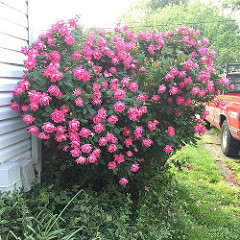

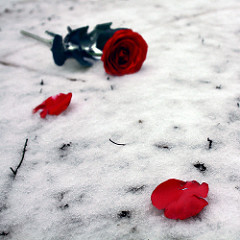

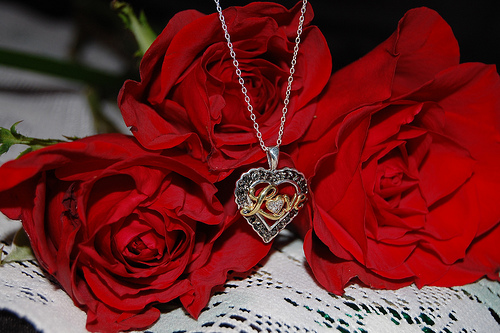

In [0]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

##4.2. Load using keras.preprocessing

In [0]:
# convert from uint8 to float32 in range [0, 1]
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [0]:
# Inspect a batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

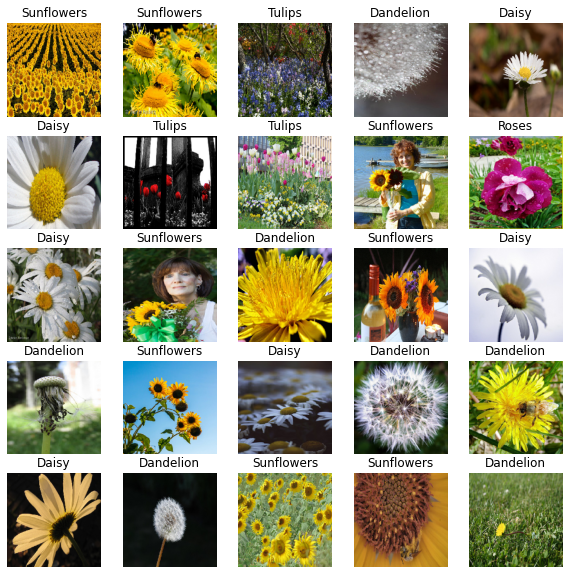

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#4.3. Load using tf.data

three downsides of preprocessing:
1. it's slow
2. it lacks fine-grained control
3. it is not well integrated with the rest of TF

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/4134441089_c8c1e6132a.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5602738326_97121e007d_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/1355787476_32e9f2a30b.jpg'
b'/root/.keras/datasets/flower_photos/daisy/5884807222_22f5326ba8_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/130733200_fbe28eea19.jpg'


In [0]:
# converts a file path to an (img, label) pair
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


##4.4. Basic methods for training

1. To be well shuffled
2. To be batched
3. Batches to be available as soon as possible

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

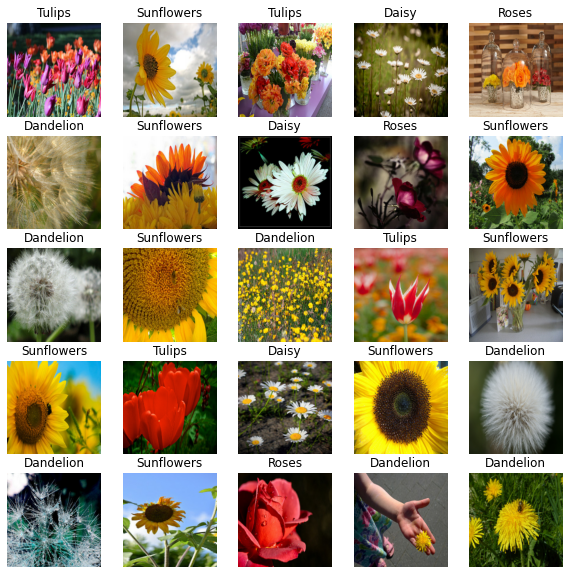

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

##4.5. Performance

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [0]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 97.12090277671814 s
329.48623 Images/s


In [0]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 13.563383102416992 s
2359.29338 Images/s


In [0]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 68.19268822669983 s
469.25852 Images/s


In [0]:
# If the dataset doesn't fit in memory use a cache file to maintain some of the advantages
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 32.54162263870239 s
983.35600 Images/s


#5. Load text



In [0]:
%tensorflow_version 2.x
!pip install -q tf-nightly
import tensorflow as tf
import tensorflow_datasets as tfds
import os

     |████████████████████████████████| 517.2MB 28kB/s 
     |████████████████████████████████| 2.9MB 46.3MB/s 
     |████████████████████████████████| 460kB 45.1MB/s 


In [0]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL+name)
  
parent_dir = os.path.dirname(text_dir)

parent_dir

811008/807992 [==============================] - 0s 0us/step


'/root/.keras/datasets'

##5.1. Load text into datasets

In [0]:
# Iterate through the files and manually create the label
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [0]:
# Combine these labeled dataset into a single dataset
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

In [0]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False) 

In [0]:
for ex in all_labeled_data.take(5):
  print(ex)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Bent as he is on battle, they will task'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'but those who were about the dead heaped up wood and built a pyre a'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'The captains of the guard, but sitting all'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Tlepolemus, son of Hercules, a man both brave and large of stature,'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'While Phoebus motionless his AEgis held,'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


##5.2. Encode text lines as numbers

map each unique word to a unique integer

In [0]:
# Build a vovabulary by tokenizing the text into a collection of individual unique words. 

# define a tokenizer
tokenizer = tfds.features.text.Tokenizer()

# Use set to avoid duplicate
vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

17178

In [0]:
# Encode examples
# The encode method takes in a string of text and returns a list of integers
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [0]:
example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)

b'Bent as he is on battle, they will task'


In [0]:
encoded_example = encoder.encode(example_text)
print(encoded_example)

[12961, 1777, 8856, 11535, 15681, 4837, 15091, 3393, 7555]


In [0]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# Dataset.map runs in graph mode
# Graph tensors do not have a value
# In graph mode you can only use TensorFlow Ops and functions
# So, you need to wrap it in a tf.py_function
# In more clear way, if you want run python code in map, you have to wrap it with tf.py_function
def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)

##5.3. Split the dataset into test and train batches


In [0]:
# use padded_batch to pad the examples to the same size
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
# Pad to the smallest per-batch size that fits all elements
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

In [0]:
# (batch_size_examples, batch_size_labels) to (example, label) pair
sample_text, sample_labels = next(iter(test_data))
sample_text[0], sample_labels[0]
# the zeros used for padding

(<tf.Tensor: shape=(16,), dtype=int64, numpy=
 array([12961,  1777,  8856, 11535, 15681,  4837, 15091,  3393,  7555,
            0,     0,     0,     0,     0,     0,     0])>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 64)

In [0]:
# the vocabulary size has increased by one because of the 0
vocab_size += 1

##5.4. Build the model

In [0]:
model = tf.keras.Sequential()
# The first layer converts integer representations to dense vector embeddings
model.add(tf.keras.layers.Embedding(vocab_size, 64)) # input and output dimensions

# The LSTM layer lets the model understand words in their context with other words. 
# Bidirectional helps to get the relationship before and after a word
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

for units in  [64, 64]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))

model.add(tf.keras.layers.Dense(3))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##5.5. Train the model

In [0]:
model.fit(train_data, epochs=3, validation_data=test_data)

Epoch 1/3
697/697 [==============================] - 28s 40ms/step - loss: 0.5139 - accuracy: 0.7503 - val_loss: 0.3950 - val_accuracy: 0.8158
Epoch 2/3
697/697 [==============================] - 29s 41ms/step - loss: 0.2983 - accuracy: 0.8676 - val_loss: 0.3812 - val_accuracy: 0.8216
Epoch 3/3
697/697 [==============================] - 28s 41ms/step - loss: 0.2261 - accuracy: 0.9004 - val_loss: 0.3999 - val_accuracy: 0.8266


In [0]:
eval_loss, eval_acc = model.evaluate(test_data)
print('\nEval loss: {:.3f}, Eval accuracy: {:.3f}'.format(eval_loss, eval_acc))

79/79 [==============================] - 2s 27ms/step - loss: 0.3999 - accuracy: 0.8266

Eval loss: 0.400, Eval accuracy: 0.827


#6. Unicode Strings

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [3]:
# tf.string dtype allows you to build tensors of byte strings. 
# Unicode strings are utf-8 encoded by default.
tf.constant(u'Thanks 😊')
# u stands for unicode to let the python2 know. In python3 the string will be treated as unicode as default

<tf.Tensor: shape=(), dtype=string, numpy=b'Thanks \xf0\x9f\x98\x8a'>

In [4]:
# A tf.string tensor can hold byte strings of varying lengths
# because the byte strings are treated as atomic units
tf.constant(["You're", "welcome!"]).shape

TensorShape([2])

##6.1. Representing Unicode

In [5]:
# Unicode string, represented as a UTF-8 encoded string scalar.
text_utf8 = tf.constant(u"语言处理")
text_utf8

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe8\xaf\xad\xe8\xa8\x80\xe5\xa4\x84\xe7\x90\x86'>

In [6]:
# Unicode string, represented as a UTF-16-BE encoded string scalar.
text_utf16be = tf.constant(u"语言处理".encode("UTF-16-BE"))
text_utf16be

<tf.Tensor: shape=(), dtype=string, numpy=b'\x8b\xed\x8a\x00Y\x04t\x06'>

In [7]:
# Unicode string, represented as a vector of Unicode code points.
text_chars = tf.constant([ord(char) for char in u"语言处理"])
text_chars

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([35821, 35328, 22788, 29702], dtype=int32)>

In [8]:
# Converting between representations

# utf8 to code points
tf.strings.unicode_decode(text_utf8,
                          input_encoding='UTF-8')

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([35821, 35328, 22788, 29702], dtype=int32)>

In [9]:
# code points to utf8
tf.strings.unicode_encode(text_chars,
                          output_encoding='UTF-8')

<tf.Tensor: shape=(), dtype=string, numpy=b'\xe8\xaf\xad\xe8\xa8\x80\xe5\xa4\x84\xe7\x90\x86'>

In [10]:
# UTF8 to other encoding
tf.strings.unicode_transcode(text_utf8,
                             input_encoding='UTF8',
                             output_encoding='UTF-16-BE')

<tf.Tensor: shape=(), dtype=string, numpy=b'\x8b\xed\x8a\x00Y\x04t\x06'>

##6.2. Batch dimensions

In [11]:
# tf.RaggedTensor: the length of the innermost dimension varies depending on
# the number of characters in each string

# A batch of Unicode strings, each represented as a UTF8-encoded string.
batch_utf8 = [s.encode('UTF-8') for s in
              [u'hÃllo',  u'What is the weather tomorrow',  u'Göödnight', u'😊']]
batch_chars_ragged = tf.strings.unicode_decode(batch_utf8,
                                               input_encoding='UTF-8')
for sentence_chars in batch_chars_ragged.to_list():
  print(sentence_chars)

[104, 195, 108, 108, 111]
[87, 104, 97, 116, 32, 105, 115, 32, 116, 104, 101, 32, 119, 101, 97, 116, 104, 101, 114, 32, 116, 111, 109, 111, 114, 114, 111, 119]
[71, 246, 246, 100, 110, 105, 103, 104, 116]
[128522]


In [12]:
# tf.RaggedTensor can be used directly
# or converts to tf.Tensor with padding
# or tf.SparseTensor

# dense tensor with padding
batch_chars_padded = batch_chars_ragged.to_tensor(default_value=-1) # fill the padding value as -1
print(batch_chars_padded.numpy())

[[   104    195    108    108    111     -1     -1     -1     -1     -1
      -1     -1     -1     -1     -1     -1     -1     -1     -1     -1
      -1     -1     -1     -1     -1     -1     -1     -1]
 [    87    104     97    116     32    105    115     32    116    104
     101     32    119    101     97    116    104    101    114     32
     116    111    109    111    114    114    111    119]
 [    71    246    246    100    110    105    103    104    116     -1
      -1     -1     -1     -1     -1     -1     -1     -1     -1     -1
      -1     -1     -1     -1     -1     -1     -1     -1]
 [128522     -1     -1     -1     -1     -1     -1     -1     -1     -1
      -1     -1     -1     -1     -1     -1     -1     -1     -1     -1
      -1     -1     -1     -1     -1     -1     -1     -1]]


In [0]:
# Sparse Tensor
batch_chars_sparse = batch_chars_ragged.to_sparse()

In [14]:
# tf.Tensor can be used directly in unicode_encode
tf.strings.unicode_encode([[99, 97, 116], [100, 111, 103], [ 99, 111, 119]],
                          output_encoding='UTF-8')

# The same as tf.RaggedTensor
tf.strings.unicode_encode(batch_chars_ragged, output_encoding='UTF-8')

# but not tf.SparseTensor --> SparseTensor focus only the non-zero elements. indices, value and shape
tf.strings.unicode_encode(
    tf.RaggedTensor.from_sparse(batch_chars_sparse),
    output_encoding='UTF-8'
)

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'h\xc3\x83llo', b'What is the weather tomorrow',
       b'G\xc3\xb6\xc3\xb6dnight', b'\xf0\x9f\x98\x8a'], dtype=object)>

In [15]:
tf.strings.unicode_encode(
    tf.RaggedTensor.from_tensor(batch_chars_padded, padding=-1),
    output_encoding='UTF-8')

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'h\xc3\x83llo', b'What is the weather tomorrow',
       b'G\xc3\xb6\xc3\xb6dnight', b'\xf0\x9f\x98\x8a'], dtype=object)>

##6.3. Unicode operations

In [16]:
# Character length
# Note that the final character takes up 4 bytes in UTF8.
thanks = u'Thanks 😊'.encode('UTF-8')
num_bytes = tf.strings.length(thanks).numpy()
num_chars = tf.strings.length(thanks, unit='UTF8_CHAR').numpy()
print('{} bytes; {} UTF-8 characters'.format(num_bytes, num_chars))

11 bytes; 8 UTF-8 characters


In [17]:
# Character substrings
# default: unit='BYTE'. With len=1, we return a single byte.
tf.strings.substr(thanks, pos=7, len=1).numpy()

b'\xf0'

In [18]:
# Specifying unit='UTF8_CHAR', we return a single character, which in this case
# is 4 bytes.
print(tf.strings.substr(thanks, pos=7, len=1, unit='UTF8_CHAR').numpy())

b'\xf0\x9f\x98\x8a'


##6.4. Split Unicode strings

In [20]:
tf.strings.unicode_split(thanks, 'UTF-8').numpy()

array([b'T', b'h', b'a', b'n', b'k', b's', b' ', b'\xf0\x9f\x98\x8a'],
      dtype=object)

##6.5. Byte offsets for characters

In [21]:
# tf.strings.unicode_decode_with_offsets is similar to unicode_decode,
# except that it returns a second tensor containing the start offset of each character.
codepoints, offsets = tf.strings.unicode_decode_with_offsets(u"🎈🎉🎊", 'UTF-8')

for (codepoint, offset) in zip(codepoints.numpy(), offsets.numpy()):
  print("At byte offset {}: codepoint {}".format(offset, codepoint))

At byte offset 0: codepoint 127880
At byte offset 4: codepoint 127881
At byte offset 8: codepoint 127882


##6.6. Unicode scripts

In [23]:
uscript = tf.strings.unicode_script([33464, 1041])
print(uscript.numpy())  # [17, 8] == [USCRIPT_HAN, USCRIPT_CYRILLIC]
print(tf.strings.unicode_script(batch_chars_ragged))

[17  8]
<tf.RaggedTensor [[25, 25, 25, 25, 25], [25, 25, 25, 25, 0, 25, 25, 0, 25, 25, 25, 0, 25, 25, 25, 25, 25, 25, 25, 0, 25, 25, 25, 25, 25, 25, 25, 25], [25, 25, 25, 25, 25, 25, 25, 25, 25], [0]]>


##6.7. Example: Simple segmentation

Segmentation is the task of splitting text into word-like units

In [0]:
# dtype: string; shape: [num_sentences]
#
# The sentences to process.  Edit this line to try out different inputs!
sentence_texts = [u'Hello, world.', u'世界こんにちは']

In [25]:
# 1. we decode the sentences into character codepoints, and 
# find the script identifier for each character

# dtype: int32; shape: [num_sentences, (num_chars_per_sentence)]
#
# sentence_char_codepoint[i, j] is the codepoint for the j'th character in
# the i'th sentence.
sentence_char_codepoint = tf.strings.unicode_decode(sentence_texts, 'UTF-8')
print(sentence_char_codepoint)

# dtype: int32; shape: [num_sentences, (num_chars_per_sentence)]
#
# sentence_char_scripts[i, j] is the unicode script of the j'th character in
# the i'th sentence.
sentence_char_script = tf.strings.unicode_script(sentence_char_codepoint)
print(sentence_char_script)

<tf.RaggedTensor [[72, 101, 108, 108, 111, 44, 32, 119, 111, 114, 108, 100, 46], [19990, 30028, 12371, 12435, 12395, 12385, 12399]]>
<tf.RaggedTensor [[25, 25, 25, 25, 25, 0, 0, 25, 25, 25, 25, 25, 0], [17, 17, 20, 20, 20, 20, 20]]>


In [27]:
# 2. we use those script identifiers to determine where word boundaries should be added.

# dtype: bool; shape: [num_sentences, (num_chars_per_sentence)]
#
# sentence_char_starts_word[i, j] is True if the j'th character in the i'th
# sentence is the start of a word.
sentence_char_starts_word = tf.concat(
    [tf.fill([sentence_char_script.nrows(), 1], True),
     tf.not_equal(sentence_char_script[:, 1:], sentence_char_script[:, :-1])],
    axis=1)

# dtype: int64; shape: [num_words]
#
# word_starts[i] is the index of the character that starts the i'th word (in
# the flattened list of characters from all sentences).
print(sentence_char_starts_word)
word_starts = tf.squeeze(tf.where(sentence_char_starts_word.values), axis=1)
print(word_starts)

<tf.RaggedTensor [[True, False, False, False, False, True, False, True, False, False, False, False, True], [True, False, True, False, False, False, False]]>
tf.Tensor([ 0  5  7 12 13 15], shape=(6,), dtype=int64)


In [28]:
# dtype: int32; shape: [num_words, (num_chars_per_word)]
#
# word_char_codepoint[i, j] is the codepoint for the j'th character in the
# i'th word.
word_char_codepoint = tf.RaggedTensor.from_row_starts(
    values=sentence_char_codepoint.values,
    row_starts=word_starts)
print(word_char_codepoint)

<tf.RaggedTensor [[72, 101, 108, 108, 111], [44, 32], [119, 111, 114, 108, 100], [46], [19990, 30028], [12371, 12435, 12395, 12385, 12399]]>


In [29]:
# we can segment the word codepoints RaggedTensor back into sentences

# dtype: int64; shape: [num_sentences]
#
# sentence_num_words[i] is the number of words in the i'th sentence.
sentence_num_words = tf.reduce_sum(
    tf.cast(sentence_char_starts_word, tf.int64),
    axis=1)

# dtype: int32; shape: [num_sentences, (num_words_per_sentence), (num_chars_per_word)]
#
# sentence_word_char_codepoint[i, j, k] is the codepoint for the k'th character
# in the j'th word in the i'th sentence.
sentence_word_char_codepoint = tf.RaggedTensor.from_row_lengths(
    values=word_char_codepoint,
    row_lengths=sentence_num_words)
print(sentence_word_char_codepoint)

<tf.RaggedTensor [[[72, 101, 108, 108, 111], [44, 32], [119, 111, 114, 108, 100], [46]], [[19990, 30028], [12371, 12435, 12395, 12385, 12399]]]>


In [30]:
tf.strings.unicode_encode(sentence_word_char_codepoint, 'UTF-8').to_list()

[[b'Hello', b', ', b'world', b'.'],
 [b'\xe4\xb8\x96\xe7\x95\x8c',
  b'\xe3\x81\x93\xe3\x82\x93\xe3\x81\xab\xe3\x81\xa1\xe3\x81\xaf']]